In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/interim/merged_yield_tables.csv")

target_variable = "tree_type"
features = [
    "yield_class",
    "age",
    "average_height",
    "dbh",
    "trees_per_ha",
    "basal_area",
]

df.head()

,id,yield_class,age,dominant_height,average_height,dbh,taper,trees_per_ha,basal_area,volume_per_ha,average_annual_age_increment,total_growth_performance,current_annual_increment,mean_annual_increment,title,tree_type
0,1,15.0,20,5.9,5.3,11.5,0.396,2585.0,26.8,54.0,2.7,63.0,NaN,3.2,Fichte Hochgebirge,coniferous
1,1,15.0,30,12.2,10.6,16.7,0.458,1708.0,37.5,180.0,6.0,208.0,14.5,6.9,Fichte Hochgebirge,coniferous
2,1,15.0,40,18.3,15.7,21.6,0.460,1266.0,46.3,334.0,8.4,397.0,18.9,9.9,Fichte Hochgebirge,coniferous
3,1,15.0,50,23.4,20.5,26.1,0.456,1003.0,53.5,499.0,10.0,605.0,20.8,12.1,Fichte Hochgebirge,coniferous
4,1,15.0,60,27.6,24.6,30.2,0.451,830.0,59.4,659.0,11.0,815.0,21.0,13.6,Fichte Hochgebirge,coniferous


In [2]:
def detect_variable_types(df, target_col=None):
    """Automatically detect variable types in a DataFrame"""
    types = {}

    for col in df.columns:
        if col == target_col:
            types[col] = "target"
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            types[col] = "datetime"
        elif pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() == 2:
                types[col] = "binary"
            else:
                types[col] = "numerical"
        elif df[col].nunique() < 20:  # Threshold for categorical
            types[col] = "categorical"
        elif df[col].dtype == "object":
            # Check if it's text (long strings) or categorical
            avg_length = df[col].astype(str).str.len().mean()
            if avg_length > 50:
                types[col] = "text"
            else:
                types[col] = "categorical"

    return types


pprint(detect_variable_types(df, target_col="tree_type"))

{'age': 'numerical',
 'average_annual_age_increment': 'numerical',
 'average_height': 'numerical',
 'basal_area': 'numerical',
 'current_annual_increment': 'numerical',
 'dbh': 'numerical',
 'dominant_height': 'numerical',
 'id': 'numerical',
 'mean_annual_increment': 'categorical',
 'taper': 'numerical',
 'title': 'categorical',
 'total_growth_performance': 'numerical',
 'tree_type': 'target',
 'trees_per_ha': 'numerical',
 'volume_per_ha': 'numerical',
 'yield_class': 'numerical'}


In [3]:
def quick_missing_analysis(df):
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100

    print("Missing Value Summary:")
    for col in df.columns:
        if missing_counts[col] > 0:
            print(
                f"  {col}: {missing_counts[col]} missing ({missing_percent[col]:.1f}%)"
            )


quick_missing_analysis(df)

Missing Value Summary:
  dominant_height: 5573 missing (38.7%)
  average_height: 5058 missing (35.1%)
  dbh: 5285 missing (36.7%)
  taper: 9973 missing (69.3%)
  trees_per_ha: 5143 missing (35.7%)
  basal_area: 4887 missing (33.9%)
  volume_per_ha: 116 missing (0.8%)
  average_annual_age_increment: 9516 missing (66.1%)
  total_growth_performance: 9243 missing (64.2%)
  current_annual_increment: 5707 missing (39.6%)
  mean_annual_increment: 5433 missing (37.7%)
  title: 597 missing (4.1%)
  tree_type: 597 missing (4.1%)


In [4]:
# Quick sanity checks for numerical data
def basic_range_check(df):
    numeric_cols = df.select_dtypes(include=["number"]).columns

    for col in numeric_cols:
        print(f"{col}: min={df[col].min()}, max={df[col].max()}")

        # Flag obviously problematic values
        if col.lower() in ["age"] and (
            df[col].min() < 0 or df[col].max() > 300
        ):  # It's about trees
            print(f"  ⚠️ Suspicious age values detected")
        elif (
            col.lower() in ["average_height", "dominant_height", "dbh", "volume_per_ha"]
            and df[col].min() < 0
        ):
            print(f"  ⚠️ Negative measure values detected")


basic_range_check(df)

id: min=1, max=213
yield_class: min=0.0, max=36.0
age: min=4, max=300
dominant_height: min=0.0, max=1919.0
average_height: min=0.0, max=74.0
dbh: min=0.4, max=514.0
taper: min=0.066, max=4.33
trees_per_ha: min=0.0, max=77650.0
basal_area: min=0.0, max=80.3
volume_per_ha: min=0.0, max=1421.0
average_annual_age_increment: min=0.1, max=70.0
total_growth_performance: min=0.0, max=2462.0
current_annual_increment: min=-0.06, max=44.9


Outlier detection using Z-score method:
yield_class: 301 outliers detected
age: 203 outliers detected
dominant_height: 1 outliers detected
average_height: 1 outliers detected
dbh: 37 outliers detected
taper: 28 outliers detected
trees_per_ha: 97 outliers detected
basal_area: 8 outliers detected
volume_per_ha: 95 outliers detected
average_annual_age_increment: 134 outliers detected
total_growth_performance: 10 outliers detected
current_annual_increment: 126 outliers detected




Outlier detection using IQR method:
yield_class: 447 outliers detected (IQR method)
age: 273 outliers detected (IQR method)
dominant_height: 8 outliers detected (IQR method)
average_height: 1 outliers detected (IQR method)
dbh: 71 outliers detected (IQR method)
taper: 101 outliers detected (IQR method)
trees_per_ha: 775 outliers detected (IQR method)
basal_area: 10 outliers detected (IQR method)
volume_per_ha: 195 outliers detected (IQR method)
average_annual_age_increment: 328 outliers detected (IQR method)
tot

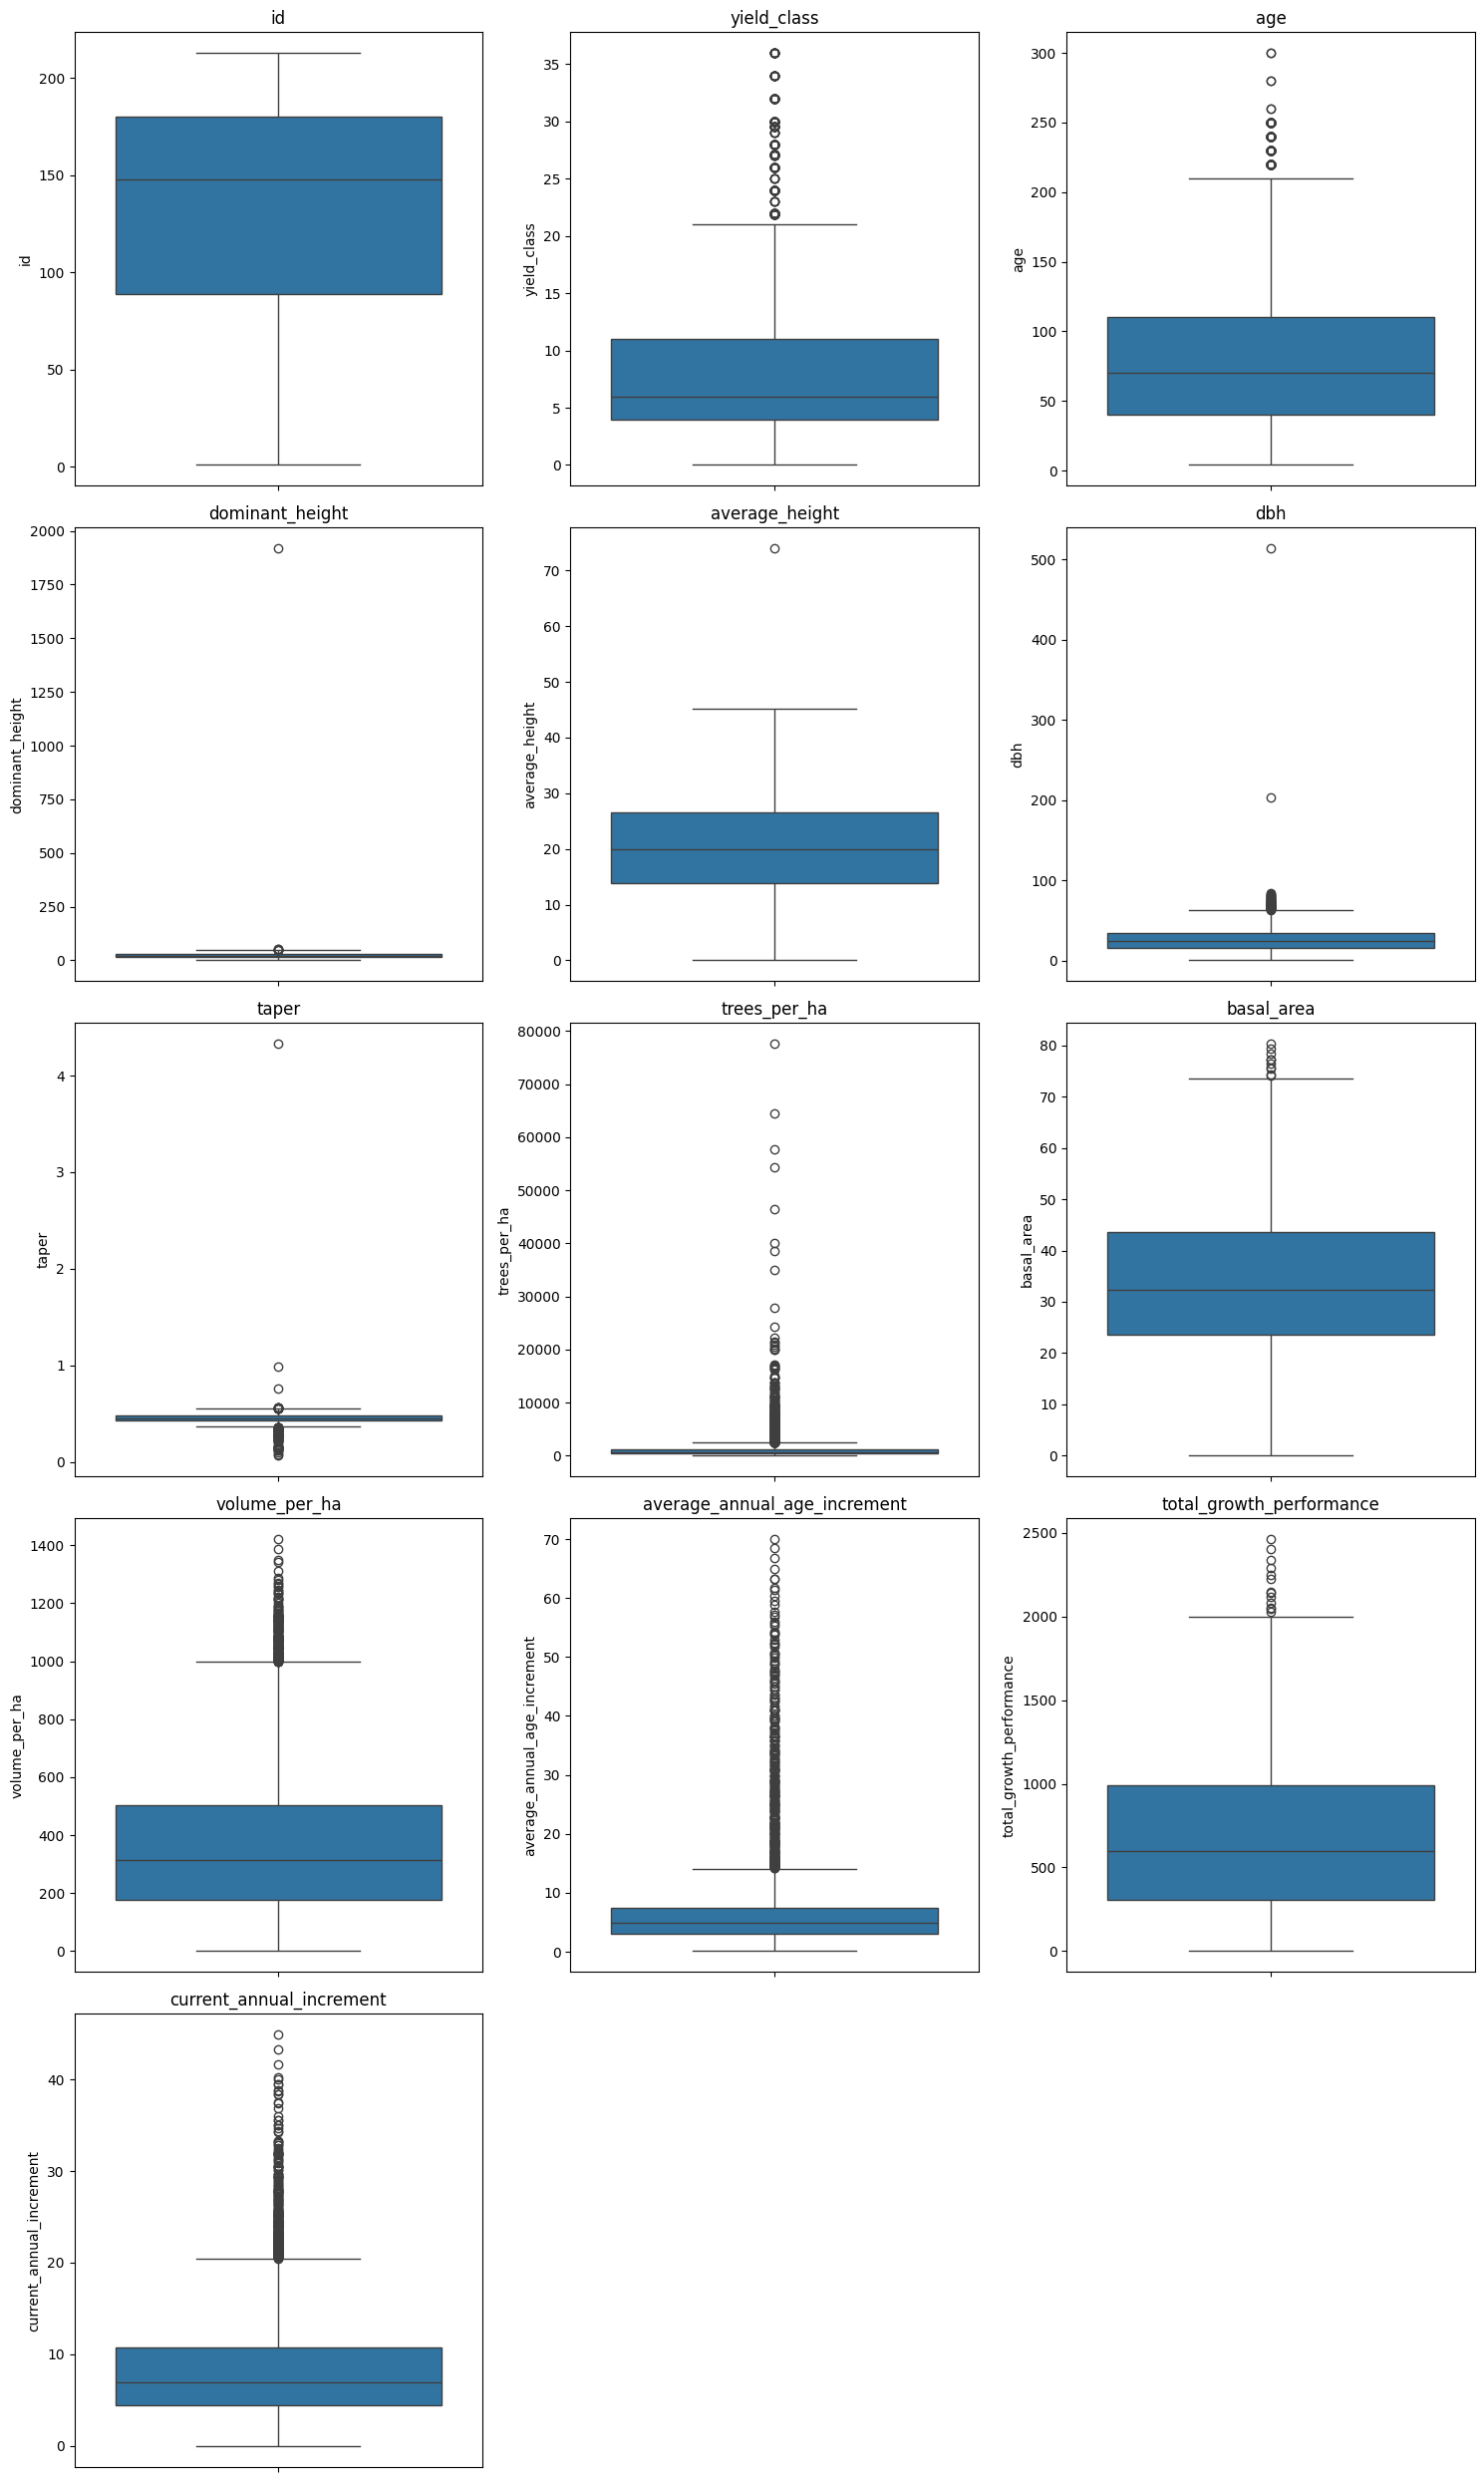

In [5]:
# Check data for outliers
def detect_outliers(df, z_thresh=3):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    outlier_summary = {}

    for col in numeric_cols:
        col_zscore = (df[col] - df[col].mean()) / df[col].std()
        outliers = df[np.abs(col_zscore) > z_thresh]
        outlier_count = len(outliers)

        if outlier_count > 0:
            outlier_summary[col] = outlier_count
            print(f"{col}: {outlier_count} outliers detected")

    if not outlier_summary:
        print("No outliers detected")

    return outlier_summary


print("Outlier detection using Z-score method:")
detect_outliers(df)


# Check for outlier with IQR method
def detect_outliers_iqr(df, k=1.5):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    outlier_summary = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)

        if outlier_count > 0:
            outlier_summary[col] = outlier_count
            print(f"{col}: {outlier_count} outliers detected (IQR method)")

    if not outlier_summary:
        print("No outliers detected (IQR method)")

    return outlier_summary


print("\n" * 3)
print("Outlier detection using IQR method:")
detect_outliers_iqr(df)


# Show outlier in boxplots
def plot_boxplots(df):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    num_plots = len(numeric_cols)
    cols = 3
    rows = (num_plots // cols) + (num_plots % cols > 0)

    plt.figure(figsize=(cols * 5, rows * 5))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(y=df[col])
        plt.title(col)

    plt.tight_layout()
    plt.show()


plot_boxplots(df)

## Check target variable distribution

We have only two classes in the target variable and they are quite balanced.

In [6]:
df["tree_type"].value_counts()

tree_type
coniferous    7398
deciduous     6403
Name: count, dtype: int64

## Leakage check

💡 Concept: Data leakage occurs when information from the future or the target variable inadvertently appears in your features, leading to overly optimistic but unrealistic performance.

In [7]:
def check_for_leakage(df, target_col, feature_cols):
    """Check for potential data leakage"""
    leakage_report = {}

    for col in feature_cols:
        # Check for perfect correlation with target
        if df[col].dtype in ["int64", "float64"]:
            correlation = df[col].corr(df[target_col].astype("category").cat.codes)
            if abs(correlation) > 0.95:
                leakage_report[col] = f"High correlation with target: {correlation:.3f}"

        # Check for target-derived features (common naming patterns)
        if any(
            word in col.lower() for word in ["target", "label", "outcome", "result"]
        ):
            leakage_report[col] = "Potentially target-derived feature name"

        # Check for future-looking features in time series
        if any(word in col.lower() for word in ["future", "next", "after", "lag_-"]):
            leakage_report[col] = "Potentially future-looking feature"

    return leakage_report


check_for_leakage(df, target_variable, features)

{}